# Chapter 9 Guide - TEST (10 Rows Only)


## 9.0 Setup

**📝 NOTE:** This is the TEST version - processes only 10 rows for fast testing. For full analysis of all 729 plays, use `9_guide_full.ipynb`.


In [ ]:
#cell 1
# NOTE: If you get ModuleNotFoundError, run: pip install -r ../requirements.txt
# Then restart your Jupyter kernel: Kernel → Restart Kernel

import pandas as pd
import numpy as np
import os
import hashlib
from dotenv import load_dotenv
from pathlib import Path

# Display settings
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 100)

# Load environment variables
load_dotenv()

# Verify setup
print("✅ Imports successful")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


✅ Imports successful
Pandas version: 2.3.0
NumPy version: 2.3.1


## 9.1

In [5]:
#cell 2
# Load World Series Game 7 play-by-play data with canonical IDs
csv_path = '../data/world_series_2025_game_7_playbyplay.csv'

# Load the data
df = pd.read_csv(csv_path)

# Create canonical ID 1: Row count (sequential ID)
df['play_id'] = range(1, len(df) + 1)

# Create canonical ID 2: Consistent hash of the text column
def create_text_hash(text):
    """Create a consistent hash from text content"""
    return hashlib.sha256(text.encode('utf-8')).hexdigest()[:16]

df['play_hash'] = df['playbyplay'].apply(create_text_hash)

# Display results
print(f"✅ Loaded {len(df)} plays from World Series Game 7")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print("\n" + "="*80)
print("Sample of data with IDs:")
print("="*80)
display(df[['play_id', 'play_hash', 'playbyplay']].head(10))


✅ Loaded 729 plays from World Series Game 7

DataFrame shape: (729, 3)

Columns: ['playbyplay', 'play_id', 'play_hash']

Sample of data with IDs:


,play_id,play_hash,playbyplay
0,1,3d2d8635357431b6,"And here we go, folks! It's the top of the first inning, and both teams are ready to set the tone for this game. The score is tied at zero, and we've got a clean slate with no outs. The excitement is palpable as we kick off this crucial matchup."
1,2,0096e8787ffb270b,"Top of the first inning here, folks, and we're set for a showdown between two of the game's giants. Max Scherzer, the veteran right-hander, is on the mound ready to face the electrifying Shohei Ohtani. The scoreboard reads all zeroes, with nobody out and the bases empty. Scherzer and Ohtani, a classic matchup to kick off this ballgame!"
2,3,f1b4dba5dae680a6,"Top of the first inning, no outs, and we're just getting started with the score knotted at zero. Max Scherzer, renowned for his precision on the mound, delivers his first pitch to the formidable Shohei Ohtani. It's a 90-mph cutter, but it misses the zone. Ball one to start the at-bat."
3,4,4787518c3e3babf0,"Top of the first inning, no outs, no score here as Max Scherzer faces off against Shohei Ohtani. Scherzer winds up and delivers a 95 mph four-seam fastball, but it's outside for ball two. The count now stands at two balls and no strikes as Ohtani shows patience early in this at-bat."
4,5,023c481a628959e1,"Top of the first, no outs, nobody on base. Scherzer on the mound, delivers a 90-mph cutter to Ohtani. Ohtani swings and fouls it back, bringing the count to 2-1. Just a whisper of contact there, but Scherzer's finding the zone early."
5,6,146487de16cd7ae0,"Top of the first inning, no score, no outs. Scherzer winds up and delivers a changeup, clocked at 86 miles per hour. Ohtani, with his keen eye, connects and sends it into right field for a clean single. The leadoff man is on, and it's a promising start for the visiting team."
6,7,2f6cf37efd2a181c,"Top of the first, no score, no outs and a 2-1 count. Scherzer on the mound facing Ohtani. He delivers, and Ohtani lines it sharply into center field for a base hit! Ohtani reaches first safely, setting the tone early in this inning."
7,8,c63579c330874d8d,"Top of the first inning, no score yet on the board, and it's a tense showdown with Max Scherzer on the mound facing the formidable Shohei Ohtani. The count is currently at 2-1, and Scherzer, known for his fierce competitiveness, is ready to deliver his fourth pitch of this at-bat. Ohtani is standing on first after reaching base earlier in the inning. The pitch comes in‚Äî"
8,9,9a0757924e4af973,"Top of the first inning, no score yet, and Shohei Ohtani is on first base with nobody out. Max Scherzer is on the mound, and he's set to face Will Smith. The count starts at 0-0, as Scherzer prepares to deliver his first pitch of the game."
9,10,ebc58d57a546f762,"Top of the first inning, no outs, and Shohei Ohtani takes a lead off first. Max Scherzer peers in at Will Smith, the count is fresh at 0-0. Scherzer winds and delivers a sizzling 94 mph four-seam fastball, and Smith watches it sail right down the pipe for strike one. The count is now 0-1, and Scherzer is off to a strong start."


## 9.2


In [ ]:
#cell 3
import openai
from pydantic import BaseModel
from typing import Optional
from tqdm.notebook import tqdm

# Load OpenAI API key
openai.api_key = os.getenv('OPENAI_API_KEY')

# Define the play-by-play extraction structure
class PlayByPlayExtraction(BaseModel):
    inning_number: int
    inning_half: str
    outs: Optional[int] = None
    score_home: Optional[int] = None
    score_away: Optional[int] = None
    pitcher_name: str
    batter_name: str
    runners_on_base: Optional[str] = None
    pre_pitch_balls: Optional[int] = None
    pre_pitch_strikes: Optional[int] = None
    post_pitch_balls: Optional[int] = None
    post_pitch_strikes: Optional[int] = None
    pitch_type: Optional[str] = None
    pitch_velocity_mph: Optional[float] = None
    pitch_result: Optional[str] = None
    ball_in_play: Optional[bool] = None

# System prompt for extracting baseball data
system_prompt = """
You are a baseball play-by-play data extraction assistant. Extract structured information from baseball commentary text.

Extract the following fields:
- inning_number: Numeric inning number (e.g., 1, 2, 3)
- inning_half: "Top" or "Bottom"
- outs: Number of outs at the moment (0, 1, or 2)
- score_home: Home team runs before this play
- score_away: Away team (visiting team) runs before this play
- pitcher_name: Full name of the pitcher (e.g., "Max Scherzer")
- batter_name: Full name of the batter (e.g., "Shohei Ohtani")
- runners_on_base: Comma-separated bases occupied (e.g., "1B", "1B,2B", "1B,3B", "None" if bases empty)
- pre_pitch_balls: Ball count before the pitch (0-3)
- pre_pitch_strikes: Strike count before the pitch (0-2)
- post_pitch_balls: Ball count after the pitch if determinable
- post_pitch_strikes: Strike count after the pitch if determinable
- pitch_type: Type of pitch (e.g., "four-seam fastball", "slider", "curveball", "changeup", "splitter")
- pitch_velocity_mph: Velocity in mph if provided (as a number)
- pitch_result: Immediate outcome - be very specific: "Ball" (pitch outside strike zone, no swing), "Strike" (called strike, no swing), "Foul" (ball hit foul - NOT in play), "In play - out" (ball hit FAIR, resulted in out), "In play - hit" (ball hit FAIR, resulted in hit/base), "Swing and miss" (swung, missed), "Hit by pitch" (batter hit by ball)
- ball_in_play: True ONLY if ball was hit FAIR into the field (NOT foul balls!). TRUE examples: "grounds out to short", "single to left", "fly ball caught", "line drive". FALSE examples: "fouls it back", "swings and misses", "strike looking", "ball outside", "foul tip". CRITICAL: Foul balls are NOT in play! Must be a FAIR ball that enters the field.

Rules:
- If information is not available in the text, return null/None
- For runners_on_base, use "None" if bases are empty
- Visiting team is "away", home team is "home"
- Extract names exactly as mentioned in the text
- Be precise with counts - distinguish between pre-pitch and post-pitch counts

Return the result as a JSON object matching the PlayByPlayExtraction structure.
"""

# Process each play-by-play entry through OpenAI
# NOTE: This will make 729 API calls - testing on first 10 rows
test_df = df.head(10).copy()

print("✅ Pydantic model and prompt ready")
print(f"✅ OpenAI API key loaded: {openai.api_key[:10]}...")
print(f"\n🔄 Processing {len(test_df)} plays...")

extracted_data = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Extracting play data"):
    try:
        completion = openai.beta.chat.completions.parse(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": row['playbyplay']}
            ],
            response_format=PlayByPlayExtraction
        )
        extracted_data.append(completion.choices[0].message.parsed.dict())
    except Exception as e:
        print(f"\n❌ Error processing play_id {row['play_id']}: {e}")
        # Append None values to maintain alignment
        extracted_data.append({field: None for field in PlayByPlayExtraction.__fields__})
        continue

# Create DataFrame from extracted data
df_extracted = pd.DataFrame(extracted_data)

# Add the original IDs to the extracted data
df_extracted['play_id'] = test_df['play_id'].values
df_extracted['play_hash'] = test_df['play_hash'].values

# Merge back to original dataframe to create wide table
df_enriched = test_df.merge(df_extracted, on=['play_id', 'play_hash'], how='left')

print(f"\n✅ Successfully extracted data from {len(df_extracted)} plays")
print(f"\nEnriched DataFrame shape: {df_enriched.shape}")
print(f"Columns: {list(df_enriched.columns)}")
print("\n" + "="*80)
print("Sample of enriched data:")
print("="*80)
display(df_enriched.head())


✅ Pydantic model and prompt ready
✅ OpenAI API key loaded: sk-proj-WA...

🔄 Processing 10 plays...


Extracting play data:   0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/h0/ckkxq40s70vc524w2v0_myw00000gp/T/ipykernel_42617/4163971639.py:80: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  extracted_data.append(completion.choices[0].message.parsed.dict())



✅ Successfully extracted data from 10 plays

Enriched DataFrame shape: (10, 19)
Columns: ['playbyplay', 'play_id', 'play_hash', 'inning_number', 'inning_half', 'outs', 'score_home', 'score_away', 'pitcher_name', 'batter_name', 'runners_on_base', 'pre_pitch_balls', 'pre_pitch_strikes', 'post_pitch_balls', 'post_pitch_strikes', 'pitch_type', 'pitch_velocity_mph', 'pitch_result', 'ball_in_play']

Sample of enriched data:


,playbyplay,play_id,play_hash,inning_number,inning_half,outs,score_home,score_away,pitcher_name,batter_name,runners_on_base,pre_pitch_balls,pre_pitch_strikes,post_pitch_balls,post_pitch_strikes,pitch_type,pitch_velocity_mph,pitch_result,ball_in_play
0,"And here we go, folks! It's the top of the first inning, and both teams are ready to set the tone for this game. The score is tied at zero, and we've got a clean slate with no outs. The excitement is palpable as we kick off this crucial matchup.",1,3d2d8635357431b6,1,Top,0.0,0.0,0.0,/null,/null,None,NaN,NaN,NaN,NaN,None,NaN,None,None
1,"Top of the first inning here, folks, and we're set for a showdown between two of the game's giants. Max Scherzer, the veteran right-hander, is on the mound ready to face the electrifying Shohei Ohtani. The scoreboard reads all zeroes, with nobody out and the bases empty. Scherzer and Ohtani, a classic matchup to kick off this ballgame!",2,0096e8787ffb270b,1,Top,0.0,0.0,0.0,Max Scherzer,Shohei Ohtani,None,NaN,NaN,NaN,NaN,None,NaN,None,None
2,"Top of the first inning, no outs, and we're just getting started with the score knotted at zero. Max Scherzer, renowned for his precision on the mound, delivers his first pitch to the formidable Shohei Ohtani. It's a 90-mph cutter, but it misses the zone. Ball one to start the at-bat.",3,f1b4dba5dae680a6,1,Top,0.0,0.0,0.0,Max Scherzer,Shohei Ohtani,None,0.0,0.0,1.0,0.0,cutter,90.0,Ball,False
3,"Top of the first inning, no outs, no score here as Max Scherzer faces off against Shohei Ohtani. Scherzer winds up and delivers a 95 mph four-seam fastball, but it's outside for ball two. The count now stands at two balls and no strikes as Ohtani shows patience early in this at-bat.",4,4787518c3e3babf0,1,Top,0.0,0.0,0.0,Max Scherzer,Shohei Ohtani,None,1.0,0.0,2.0,0.0,four-seam fastball,95.0,Ball,False
4,"Top of the first, no outs, nobody on base. Scherzer on the mound, delivers a 90-mph cutter to Ohtani. Ohtani swings and fouls it back, bringing the count to 2-1. Just a whisper of contact there, but Scherzer's finding the zone early.",5,023c481a628959e1,1,Top,0.0,NaN,NaN,Scherzer,Ohtani,None,2.0,0.0,2.0,1.0,cutter,90.0,Foul,False


## 9.3 


In [9]:
#cell 4
# Define canonical reference data
pitcher_reference = {
    28976: "Max Scherzer",
    39832: "Shohei Ohtani",
    4417203: "Justin Wrobleski",
    33190: "Tyler Glasnow",
    4917888: "Louis Varland",
    33148: "Chris Bassitt",
    4949041: "Trey Yesavage",
    4417806: "Emmet Sheehan",
    33841: "Jeff Hoffman",
    33748: "Blake Snell",
    4872587: "Yoshinobu Yamamoto",
    37793: "Seranthony Dominguez",
    40912: "Shane Bieber"
}

batter_reference = {
    39832: "Shohei Ohtani",
    38309: "Will Smith",
    30193: "Freddie Freeman",
    33039: "Mookie Betts",
    32078: "George Springer",
    35682: "Nathan Lukes",
    35002: "Vladimir Guerrero Jr.",
    33303: "Max Muncy",
    33377: "Teoscar Hernandez",
    39907: "Tommy Edman",
    38904: "Bo Bichette",
    4997589: "Addison Barger",
    42081: "Alejandro Kirk",
    40963: "Daulton Varsho",
    41287: "Ernie Clement",
    37729: "Andres Gimenez",
    31358: "Enrique Hernandez",
    30791: "Miguel Rojas",
    4997181: "Davis Schneider",
    42468: "Andy Pages",
    39105: "Myles Straw",
    33572: "Isiah Kiner-Falefa"
}

pitch_type_reference = {
    "FC": "Cutter",
    "FF": "Four-seam FB",
    "CH": "Changeup",
    "CU": "Curve",
    "SL": "Slider",
    "ST": "Sweeper",
    "FS": "Splitter",
    "SI": "Sinker",
    "KC": "Knuckle Curve"
}

print("✅ Reference data loaded:")
print(f"   - {len(pitcher_reference)} pitchers")
print(f"   - {len(batter_reference)} batters")
print(f"   - {len(pitch_type_reference)} pitch types")


✅ Reference data loaded:
   - 13 pitchers
   - 22 batters
   - 9 pitch types


In [10]:
#cell 5
# Define Pydantic models for canonical mapping
class PlayerMapping(BaseModel):
    canonical_id: int
    canonical_name: str
    confidence: str  # "high", "medium", "low"

class PitchTypeMapping(BaseModel):
    canonical_abbr: str
    canonical_text: str
    confidence: str  # "high", "medium", "low"

# Create mapping prompts
def create_pitcher_mapping_prompt(pitcher_list):
    pitcher_str = "\n".join([f"ID: {pid}, Name: {name}" for pid, name in pitcher_list.items()])
    return f"""
You are a baseball data quality expert. Match the provided pitcher name to the correct canonical pitcher from this list:

{pitcher_str}

Rules:
- Match based on last name, full name, or any reasonable variation
- Examples: "Scherzer" should match "Max Scherzer", "Ohtani" should match "Shohei Ohtani"
- Return the canonical_id and canonical_name from the list above
- Set confidence to "high" for exact matches, "medium" for last name only, "low" for uncertain matches
- If no reasonable match exists, use the closest match and set confidence to "low"

Return a JSON object with: canonical_id (int), canonical_name (str), confidence (str)
"""

def create_batter_mapping_prompt(batter_list):
    batter_str = "\n".join([f"ID: {bid}, Name: {name}" for bid, name in batter_list.items()])
    return f"""
You are a baseball data quality expert. Match the provided batter name to the correct canonical batter from this list:

{batter_str}

Rules:
- Match based on last name, full name, or any reasonable variation
- Examples: "Guerrero" should match "Vladimir Guerrero Jr.", "Springer" should match "George Springer"
- Return the canonical_id and canonical_name from the list above
- Set confidence to "high" for exact matches, "medium" for last name only, "low" for uncertain matches
- If no reasonable match exists, use the closest match and set confidence to "low"

Return a JSON object with: canonical_id (int), canonical_name (str), confidence (str)
"""

def create_pitch_type_mapping_prompt(pitch_type_list):
    pitch_str = "\n".join([f"Abbr: {abbr}, Text: {text}" for abbr, text in pitch_type_list.items()])
    return f"""
You are a baseball data quality expert. Match the provided pitch type to the correct canonical pitch type from this list:

{pitch_str}

Rules:
- Match based on common pitch terminology and abbreviations
- Examples: "fastball" or "four-seam fastball" → "Four-seam FB" (FF)
- "curve" or "curveball" → "Curve" (CU)
- "slider" → "Slider" (SL)
- Handle variations like "four seam fastball", "4-seam FB", etc.
- Return the canonical_abbr and canonical_text from the list above
- Set confidence to "high" for clear matches, "medium" for likely matches, "low" for uncertain
- If null/None provided, return null values with low confidence

Return a JSON object with: canonical_abbr (str), canonical_text (str), confidence (str)
"""

pitcher_prompt = create_pitcher_mapping_prompt(pitcher_reference)
batter_prompt = create_batter_mapping_prompt(batter_reference)
pitch_type_prompt = create_pitch_type_mapping_prompt(pitch_type_reference)

print("✅ Mapping prompts created")


✅ Mapping prompts created


In [11]:
#cell 6
# Map pitchers, batters, and pitch types to canonical IDs
print("🔄 Mapping to canonical IDs...\n")

# Initialize lists to store mappings
pitcher_mappings = []
batter_mappings = []
pitch_type_mappings = []

for idx, row in tqdm(df_enriched.iterrows(), total=len(df_enriched), desc="Mapping to canonical IDs"):
    
    # Map pitcher
    if pd.notna(row['pitcher_name']):
        try:
            completion = openai.beta.chat.completions.parse(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": pitcher_prompt},
                    {"role": "user", "content": f"Pitcher name: {row['pitcher_name']}"}
                ],
                response_format=PlayerMapping
            )
            pitcher_mappings.append(completion.choices[0].message.parsed.dict())
        except Exception as e:
            print(f"\n❌ Error mapping pitcher '{row['pitcher_name']}': {e}")
            pitcher_mappings.append({"canonical_id": None, "canonical_name": None, "confidence": "low"})
    else:
        pitcher_mappings.append({"canonical_id": None, "canonical_name": None, "confidence": "low"})
    
    # Map batter
    if pd.notna(row['batter_name']):
        try:
            completion = openai.beta.chat.completions.parse(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": batter_prompt},
                    {"role": "user", "content": f"Batter name: {row['batter_name']}"}
                ],
                response_format=PlayerMapping
            )
            batter_mappings.append(completion.choices[0].message.parsed.dict())
        except Exception as e:
            print(f"\n❌ Error mapping batter '{row['batter_name']}': {e}")
            batter_mappings.append({"canonical_id": None, "canonical_name": None, "confidence": "low"})
    else:
        batter_mappings.append({"canonical_id": None, "canonical_name": None, "confidence": "low"})
    
    # Map pitch type
    if pd.notna(row['pitch_type']):
        try:
            completion = openai.beta.chat.completions.parse(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": pitch_type_prompt},
                    {"role": "user", "content": f"Pitch type: {row['pitch_type']}"}
                ],
                response_format=PitchTypeMapping
            )
            pitch_type_mappings.append(completion.choices[0].message.parsed.dict())
        except Exception as e:
            print(f"\n❌ Error mapping pitch type '{row['pitch_type']}': {e}")
            pitch_type_mappings.append({"canonical_abbr": None, "canonical_text": None, "confidence": "low"})
    else:
        pitch_type_mappings.append({"canonical_abbr": None, "canonical_text": None, "confidence": "low"})

# Add mapped columns to dataframe
df_enriched['pitcher_id'] = [m['canonical_id'] for m in pitcher_mappings]
df_enriched['pitcher_canonical_name'] = [m['canonical_name'] for m in pitcher_mappings]
df_enriched['pitcher_confidence'] = [m['confidence'] for m in pitcher_mappings]

df_enriched['batter_id'] = [m['canonical_id'] for m in batter_mappings]
df_enriched['batter_canonical_name'] = [m['canonical_name'] for m in batter_mappings]
df_enriched['batter_confidence'] = [m['confidence'] for m in batter_mappings]

df_enriched['pitch_type_abbr'] = [m['canonical_abbr'] for m in pitch_type_mappings]
df_enriched['pitch_type_canonical'] = [m['canonical_text'] for m in pitch_type_mappings]
df_enriched['pitch_type_confidence'] = [m['confidence'] for m in pitch_type_mappings]

print(f"\n✅ Successfully mapped canonical IDs")
print(f"\nEnriched DataFrame shape: {df_enriched.shape}")
print(f"Total columns: {len(df_enriched.columns)}")
print("\n" + "="*80)
print("Sample with canonical mappings:")
print("="*80)
display(df_enriched[['play_id', 'pitcher_name', 'pitcher_id', 'pitcher_canonical_name', 
                      'batter_name', 'batter_id', 'batter_canonical_name',
                      'pitch_type', 'pitch_type_abbr', 'pitch_type_canonical']].head())

print("\n" + "="*80)
print("Confidence distribution:")
print("="*80)
print(f"Pitcher confidence: {df_enriched['pitcher_confidence'].value_counts().to_dict()}")
print(f"Batter confidence: {df_enriched['batter_confidence'].value_counts().to_dict()}")
print(f"Pitch type confidence: {df_enriched['pitch_type_confidence'].value_counts().to_dict()}")


🔄 Mapping to canonical IDs...



Mapping to canonical IDs:   0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/h0/ckkxq40s70vc524w2v0_myw00000gp/T/ipykernel_42617/2715995637.py:23: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  pitcher_mappings.append(completion.choices[0].message.parsed.dict())
/var/folders/h0/ckkxq40s70vc524w2v0_myw00000gp/T/ipykernel_42617/2715995637.py:41: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  batter_mappings.append(completion.choices[0].message.parsed.dict())
/var/folders/h0/ckkxq40s70vc524w2v0_myw00000gp/T/ipykernel_42617/2715995637.py:59: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https:


✅ Successfully mapped canonical IDs

Enriched DataFrame shape: (10, 28)
Total columns: 28

Sample with canonical mappings:


,play_id,pitcher_name,pitcher_id,pitcher_canonical_name,batter_name,batter_id,batter_canonical_name,pitch_type,pitch_type_abbr,pitch_type_canonical
0,1,/null,28976,Max Scherzer,/null,32078,George Springer,None,None,None
1,2,Max Scherzer,28976,Max Scherzer,Shohei Ohtani,39832,Shohei Ohtani,None,None,None
2,3,Max Scherzer,28976,Max Scherzer,Shohei Ohtani,39832,Shohei Ohtani,cutter,FC,Cutter
3,4,Max Scherzer,28976,Max Scherzer,Shohei Ohtani,39832,Shohei Ohtani,four-seam fastball,FF,Four-seam FB
4,5,Scherzer,28976,Max Scherzer,Ohtani,39832,Shohei Ohtani,cutter,FC,Cutter



Confidence distribution:
Pitcher confidence: {'high': 7, 'medium': 2, 'low': 1}
Batter confidence: {'high': 8, 'low': 1, 'medium': 1}
Pitch type confidence: {'low': 5, 'high': 5}


## 9.4


In [12]:
#cell 7
# Define Pydantic model for advanced transformations
class PlayAnalysis(BaseModel):
    key_moment: bool
    excitement: int  # Scale of 1-10

# Create system prompt for play analysis
system_prompt_analysis = """
You are a baseball narrative analyst. Analyze the provided play-by-play commentary and determine:

1. **key_moment** (boolean): Is this a key moment in the game?
   - TRUE for: home runs, game-tying hits, go-ahead runs, critical strikeouts, bases-loaded situations, 
     double plays that end threats, extra-inning plays, close game situations, defensive gems
   - TRUE for: any play where the commentary suggests high stakes, tension, or game-changing impact
   - FALSE for: routine outs, standard balls/strikes, typical fly outs, grounders with no drama
   - Look for phrases like "crucial", "pivotal", "clutch", "ties the game", "takes the lead", etc.

2. **excitement** (integer 1-10): Rate the excitement level of this play
   - 1-2: Routine play, minimal drama (standard out, foul ball, ball/strike)
   - 3-4: Somewhat notable (base hit, walk, strikeout in normal situation)
   - 5-6: Moderately exciting (extra-base hit, key defensive play, close play at base)
   - 7-8: Very exciting (home run, bases loaded, clutch hit, game-changing play)
   - 9-10: Extremely exciting (walk-off hit, game-tying homer, incredible defensive play, high-stakes moment)
   
Consider factors:
- Score situation (close game = higher excitement)
- Inning (later innings = higher stakes)
- Base runners (more runners = more tension)
- Outs (2 outs = more pressure)
- Game impact (does this change the score or game state significantly?)
- Commentary tone (exclamation marks, dramatic language = higher excitement)

Return a JSON object with: key_moment (bool), excitement (int 1-10)
"""

print("✅ Play analysis model and prompt ready")
print("\nThis will identify key moments and measure excitement throughout the game!")


✅ Play analysis model and prompt ready

This will identify key moments and measure excitement throughout the game!


In [13]:
#cell 8
# Analyze each play for key moments and excitement
print("🔄 Analyzing plays for key moments and excitement...\n")

play_analyses = []

for idx, row in tqdm(df_enriched.iterrows(), total=len(df_enriched), desc="Analyzing plays"):
    try:
        completion = openai.beta.chat.completions.parse(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt_analysis},
                {"role": "user", "content": row['playbyplay']}
            ],
            response_format=PlayAnalysis
        )
        play_analyses.append(completion.choices[0].message.parsed.dict())
    except Exception as e:
        print(f"\n❌ Error analyzing play_id {row['play_id']}: {e}")
        # Default values for failed analysis
        play_analyses.append({"key_moment": False, "excitement": 1})
        continue

# Add analysis columns to dataframe
df_enriched['key_moment'] = [a['key_moment'] for a in play_analyses]
df_enriched['excitement'] = [a['excitement'] for a in play_analyses]

print(f"\n✅ Successfully analyzed {len(play_analyses)} plays")
print(f"\nEnriched DataFrame shape: {df_enriched.shape}")
print(f"Total columns: {len(df_enriched.columns)}")

print("\n" + "="*80)
print("Key Moment Summary:")
print("="*80)
key_moments_count = df_enriched['key_moment'].sum()
print(f"Total key moments identified: {key_moments_count} out of {len(df_enriched)} plays")
print(f"Percentage of key moments: {(key_moments_count/len(df_enriched)*100):.1f}%")

print("\n" + "="*80)
print("Excitement Distribution:")
print("="*80)
print(df_enriched['excitement'].value_counts().sort_index())
print(f"\nAverage excitement: {df_enriched['excitement'].mean():.2f}")
print(f"Max excitement: {df_enriched['excitement'].max()}")
print(f"Min excitement: {df_enriched['excitement'].min()}")

print("\n" + "="*80)
print("Sample of most exciting plays:")
print("="*80)
top_exciting = df_enriched.nlargest(5, 'excitement')[['play_id', 'inning_number', 'inning_half', 
                                                        'pitcher_name', 'batter_name', 
                                                        'key_moment', 'excitement', 'playbyplay']]
for idx, play in top_exciting.iterrows():
    print(f"\nPlay #{play['play_id']} - Excitement: {play['excitement']}/10 - Key Moment: {play['key_moment']}")
    print(f"Inning: {play['inning_half']} {play['inning_number']} | {play['pitcher_name']} vs {play['batter_name']}")
    print(f"Play: {play['playbyplay'][:200]}...")

print("\n" + "="*80)
print("Final enriched dataset ready for visualization!")
print("="*80)
display(df_enriched[['play_id', 'inning_number', 'pitcher_name', 'batter_name', 
                      'key_moment', 'excitement']].head(10))


🔄 Analyzing plays for key moments and excitement...



Analyzing plays:   0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/h0/ckkxq40s70vc524w2v0_myw00000gp/T/ipykernel_42617/338747101.py:17: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  play_analyses.append(completion.choices[0].message.parsed.dict())



✅ Successfully analyzed 10 plays

Enriched DataFrame shape: (10, 30)
Total columns: 30

Key Moment Summary:
Total key moments identified: 0 out of 10 plays
Percentage of key moments: 0.0%

Excitement Distribution:
excitement
1    1
2    4
3    2
4    2
5    1
Name: count, dtype: int64

Average excitement: 2.80
Max excitement: 5
Min excitement: 1

Sample of most exciting plays:

Play #1 - Excitement: 5/10 - Key Moment: False
Inning: Top 1 | /null vs /null
Play: And here we go, folks! It's the top of the first inning, and both teams are ready to set the tone for this game. The score is tied at zero, and we've got a clean slate with no outs. The excitement is ...

Play #6 - Excitement: 4/10 - Key Moment: False
Inning: Top 1 | Scherzer vs Ohtani
Play: Top of the first inning, no score, no outs. Scherzer winds up and delivers a changeup, clocked at 86 miles per hour. Ohtani, with his keen eye, connects and sends it into right field for a clean singl...

Play #7 - Excitement: 4/10 - Key Mom

,play_id,inning_number,pitcher_name,batter_name,key_moment,excitement
0,1,1,/null,/null,False,5
1,2,1,Max Scherzer,Shohei Ohtani,False,3
2,3,1,Max Scherzer,Shohei Ohtani,False,1
3,4,1,Max Scherzer,Shohei Ohtani,False,2
4,5,1,Scherzer,Ohtani,False,2
5,6,1,Scherzer,Ohtani,False,4
6,7,1,Scherzer,Ohtani,False,4
7,8,1,Max Scherzer,Shohei Ohtani,False,3
8,9,1,Max Scherzer,Will Smith,False,2
9,10,1,Max Scherzer,Will Smith,False,2


## 9.5

In [18]:
#cell 9
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Visualization libraries loaded")


Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


✅ Visualization libraries loaded


### Analysis 1: Excitement Throughout the Game


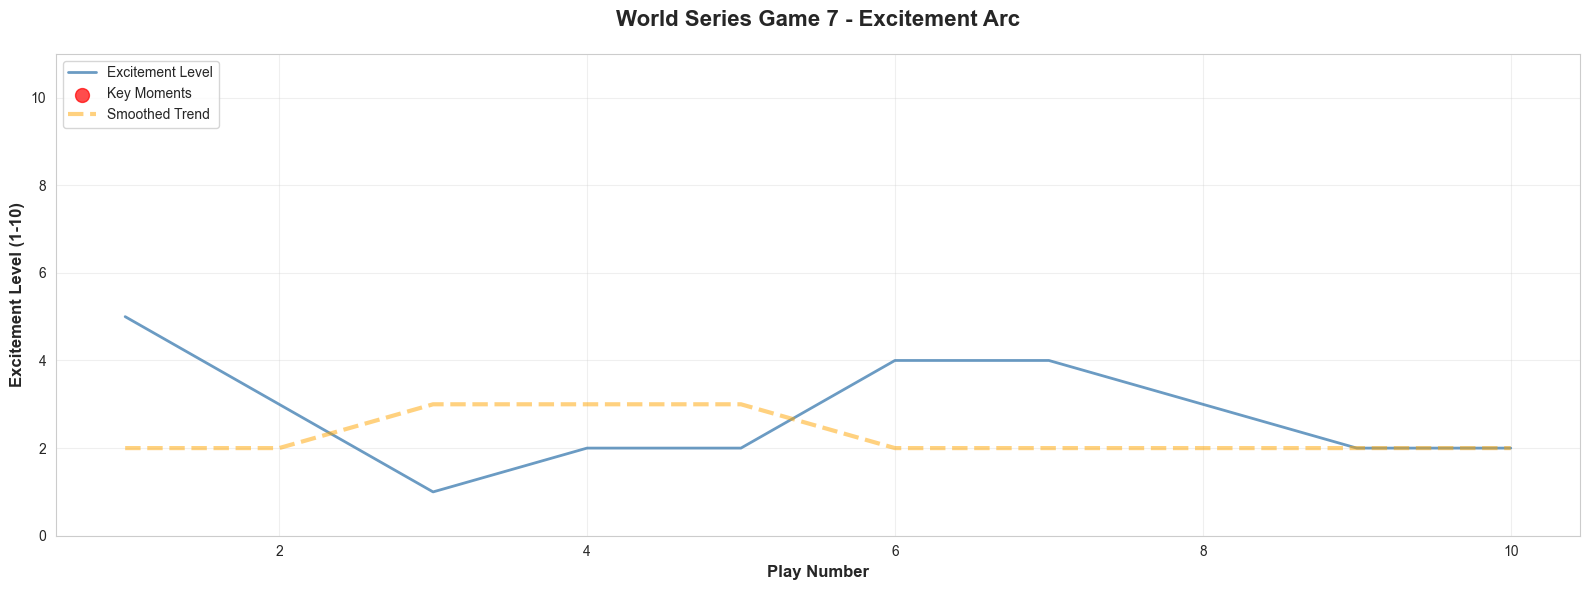


Excitement Statistics:
Total plays analyzed: 10
Average excitement: 2.80
Peak excitement: 5
Key moments: 0 (0.0%)

Most exciting play: Play #1


,play_id,excitement,key_moment,inning_number,inning_half
0,1,5,False,1,Top
1,2,3,False,1,Top
2,3,1,False,1,Top
3,4,2,False,1,Top
4,5,2,False,1,Top


In [19]:
#cell 10
# Analysis 1: Map excitement over play number
excitement_df = df_enriched[['play_id', 'excitement', 'key_moment', 'inning_number', 'inning_half']].copy()

# Create the excitement arc visualization
fig, ax = plt.subplots(figsize=(16, 6))

# Plot excitement line
ax.plot(excitement_df['play_id'], excitement_df['excitement'], 
        linewidth=2, color='steelblue', alpha=0.8, label='Excitement Level')

# Highlight key moments
key_moments = excitement_df[excitement_df['key_moment'] == True]
ax.scatter(key_moments['play_id'], key_moments['excitement'], 
          color='red', s=100, zorder=5, alpha=0.7, label='Key Moments')

# Add smoothed trend line
from scipy.ndimage import uniform_filter1d
smoothed = uniform_filter1d(excitement_df['excitement'], size=10)
ax.plot(excitement_df['play_id'], smoothed, 
        linewidth=3, color='orange', alpha=0.5, linestyle='--', label='Smoothed Trend')

# Formatting
ax.set_xlabel('Play Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Excitement Level (1-10)', fontsize=12, fontweight='bold')
ax.set_title('World Series Game 7 - Excitement Arc', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 11)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Excitement Statistics:")
print("="*80)
print(f"Total plays analyzed: {len(excitement_df)}")
print(f"Average excitement: {excitement_df['excitement'].mean():.2f}")
print(f"Peak excitement: {excitement_df['excitement'].max()}")
print(f"Key moments: {key_moments.shape[0]} ({(key_moments.shape[0]/len(excitement_df)*100):.1f}%)")
print(f"\nMost exciting play: Play #{excitement_df.loc[excitement_df['excitement'].idxmax(), 'play_id']}")

display(excitement_df.head())


### Analysis 2: Pitcher Performance


PITCHER PERFORMANCE ANALYSIS

Total pitchers: 1
Total pitches analyzed: 10


,pitcher_id,pitcher_name,avg_pitch_speed_mph,most_frequent_pitch,total_pitches
0,28976,Max Scherzer,91.0,Cutter,10


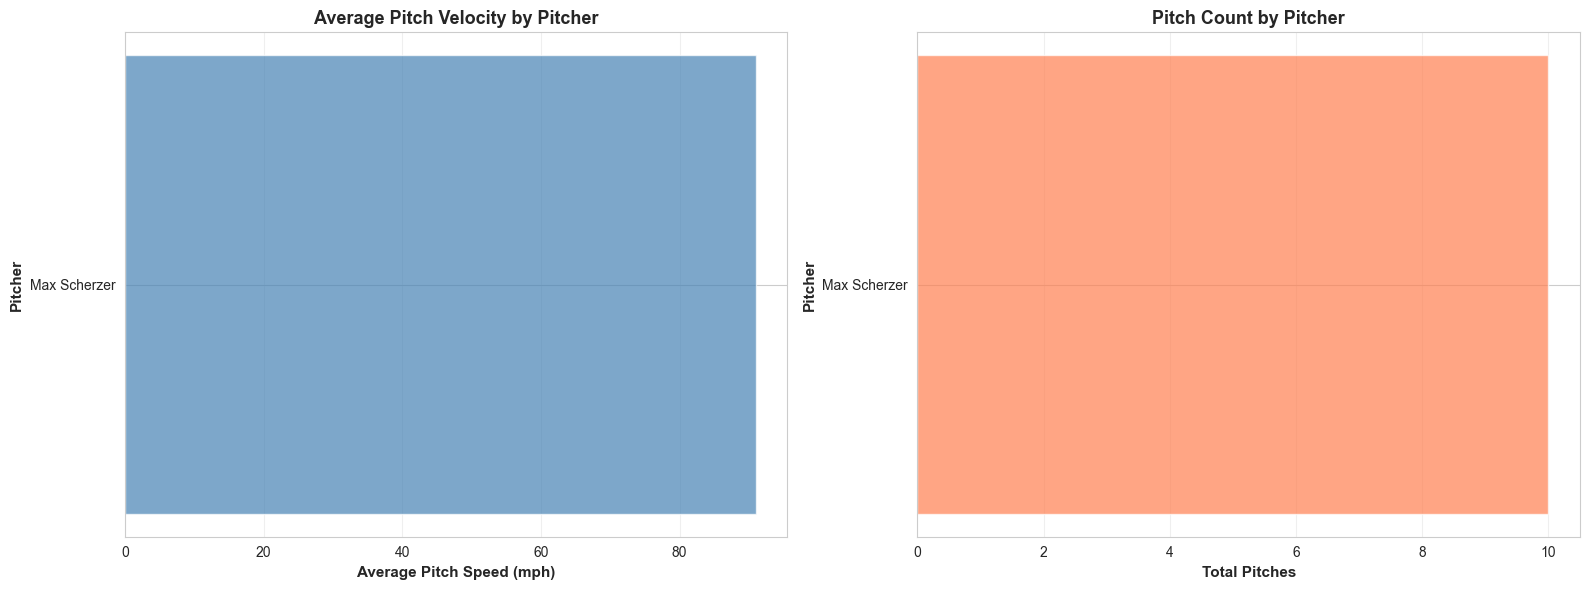

In [20]:
#cell 11
# Analysis 2: Group by pitcher - most frequent pitch type and average velocity
pitcher_analysis = df_enriched[df_enriched['pitcher_id'].notna()].copy()

# Get most frequent pitch type per pitcher
def get_most_frequent_pitch(group):
    pitch_counts = group['pitch_type_canonical'].value_counts()
    if len(pitch_counts) > 0:
        return pitch_counts.index[0]
    return None

pitcher_stats = pitcher_analysis.groupby(['pitcher_id', 'pitcher_canonical_name']).agg({
    'pitch_velocity_mph': 'mean',
    'pitch_type_canonical': lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else None,
    'play_id': 'count'  # Count of pitches
}).reset_index()

pitcher_stats.columns = ['pitcher_id', 'pitcher_name', 'avg_pitch_speed_mph', 'most_frequent_pitch', 'total_pitches']

# Round the average speed
pitcher_stats['avg_pitch_speed_mph'] = pitcher_stats['avg_pitch_speed_mph'].round(1)

# Sort by total pitches
pitcher_stats = pitcher_stats.sort_values('total_pitches', ascending=False)

print("="*80)
print("PITCHER PERFORMANCE ANALYSIS")
print("="*80)
print(f"\nTotal pitchers: {len(pitcher_stats)}")
print(f"Total pitches analyzed: {pitcher_stats['total_pitches'].sum()}")

display(pitcher_stats)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Average pitch speed by pitcher
pitcher_stats_sorted = pitcher_stats.sort_values('avg_pitch_speed_mph', ascending=True)
ax1.barh(pitcher_stats_sorted['pitcher_name'], pitcher_stats_sorted['avg_pitch_speed_mph'], 
         color='steelblue', alpha=0.7)
ax1.set_xlabel('Average Pitch Speed (mph)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Pitcher', fontsize=11, fontweight='bold')
ax1.set_title('Average Pitch Velocity by Pitcher', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Chart 2: Total pitches by pitcher
pitcher_stats_sorted2 = pitcher_stats.sort_values('total_pitches', ascending=True)
ax2.barh(pitcher_stats_sorted2['pitcher_name'], pitcher_stats_sorted2['total_pitches'], 
         color='coral', alpha=0.7)
ax2.set_xlabel('Total Pitches', fontsize=11, fontweight='bold')
ax2.set_ylabel('Pitcher', fontsize=11, fontweight='bold')
ax2.set_title('Pitch Count by Pitcher', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### Analysis 3: Batter Performance


BATTER PERFORMANCE ANALYSIS

Total batters: 3
Total plate appearances: 10
Total balls: 5
Total strikes: 2
Total balls in play: 2


,batter_id,batter_name,total_balls,total_strikes,balls_in_play,plate_appearances,total_pitches_seen,contact_rate
2,39832,Shohei Ohtani,5,1,2,7,6,33.3
1,38309,Will Smith,0,1,0,2,1,0.0
0,32078,George Springer,0,0,0,1,0,0.0


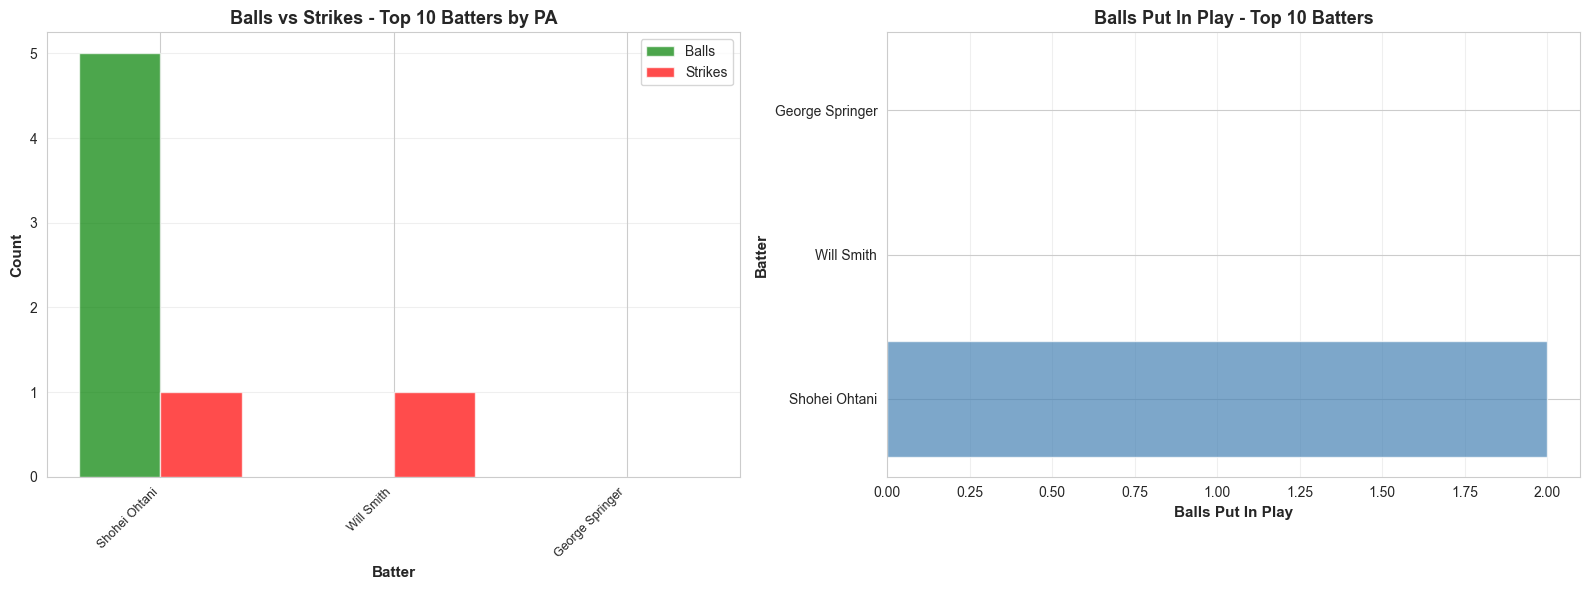


Top 5 Batters by Contact Rate:


,batter_name,plate_appearances,total_pitches_seen,balls_in_play,contact_rate
2,Shohei Ohtani,7,6,2,33.3
1,Will Smith,2,1,0,0.0
0,George Springer,1,0,0,0.0


In [21]:
#cell 12
# Analysis 3: Group by batter - sum of balls, strikes, and balls in play
batter_analysis = df_enriched[df_enriched['batter_id'].notna()].copy()

# Calculate total balls and strikes faced
batter_stats = batter_analysis.groupby(['batter_id', 'batter_canonical_name']).agg({
    'post_pitch_balls': lambda x: x.sum() if x.notna().any() else 0,
    'post_pitch_strikes': lambda x: x.sum() if x.notna().any() else 0,
    'ball_in_play': lambda x: x.sum() if x.notna().any() else 0,
    'play_id': 'count'  # Plate appearances
}).reset_index()

batter_stats.columns = ['batter_id', 'batter_name', 'total_balls', 'total_strikes', 'balls_in_play', 'plate_appearances']

# Convert to integers
batter_stats['total_balls'] = batter_stats['total_balls'].fillna(0).astype(int)
batter_stats['total_strikes'] = batter_stats['total_strikes'].fillna(0).astype(int)
batter_stats['balls_in_play'] = batter_stats['balls_in_play'].fillna(0).astype(int)

# Calculate additional metrics
batter_stats['total_pitches_seen'] = batter_stats['total_balls'] + batter_stats['total_strikes']
batter_stats['contact_rate'] = (batter_stats['balls_in_play'] / batter_stats['total_pitches_seen'] * 100).round(1)
batter_stats['contact_rate'] = batter_stats['contact_rate'].fillna(0)

# Sort by plate appearances
batter_stats = batter_stats.sort_values('plate_appearances', ascending=False)

print("="*80)
print("BATTER PERFORMANCE ANALYSIS")
print("="*80)
print(f"\nTotal batters: {len(batter_stats)}")
print(f"Total plate appearances: {batter_stats['plate_appearances'].sum()}")
print(f"Total balls: {batter_stats['total_balls'].sum()}")
print(f"Total strikes: {batter_stats['total_strikes'].sum()}")
print(f"Total balls in play: {batter_stats['balls_in_play'].sum()}")

display(batter_stats)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Balls vs Strikes for top 10 batters
top_batters = batter_stats.head(10)
x = np.arange(len(top_batters))
width = 0.35

ax1.bar(x - width/2, top_batters['total_balls'], width, label='Balls', color='green', alpha=0.7)
ax1.bar(x + width/2, top_batters['total_strikes'], width, label='Strikes', color='red', alpha=0.7)
ax1.set_xlabel('Batter', fontsize=11, fontweight='bold')
ax1.set_ylabel('Count', fontsize=11, fontweight='bold')
ax1.set_title('Balls vs Strikes - Top 10 Batters by PA', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(top_batters['batter_name'], rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Chart 2: Balls in play for top 10 batters
ax2.barh(top_batters['batter_name'], top_batters['balls_in_play'], 
         color='steelblue', alpha=0.7)
ax2.set_xlabel('Balls Put In Play', fontsize=11, fontweight='bold')
ax2.set_ylabel('Batter', fontsize=11, fontweight='bold')
ax2.set_title('Balls Put In Play - Top 10 Batters', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Top 5 Batters by Contact Rate:")
print("="*80)
display(batter_stats[['batter_name', 'plate_appearances', 'total_pitches_seen', 
                       'balls_in_play', 'contact_rate']].head())
